# The Battle of Neighborhood

## Table of contents

* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Results](#Results)
* [Discussion](#Discussion)
* [Conclusion](#Conclusion)

## Introduction

### Background:

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 as of 2016. Current to 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. The city is the anchor of the Golden Horseshoe, an urban agglomeration of 9,245,438 people (as of 2016) surrounding the western end of Lake Ontario. Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.

The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. Toronto is a prominent centre for music, theatre, motion picture production, and television production and is home to the headquarters of Canada's major national broadcast networks and media outlets. Its varied cultural institutions, which include numerous museums and galleries, festivals and public events, entertainment districts, national historic sites, and sports activities, attract over 43 million tourists each year.

### Business Proposal:

The major purpose of this project is to explore the City of Toronto neighbourhoods for the optimal location to open a shopping mall. To study and analyze the neighborhoods of Toronto city,  group them into similar clusters and analyze those clusters to gather meaningful information. That information can be used to find out locations that are more suitable to open a shopping mall. Good locations allow ready access, attract large numbers of customers, and increase the potential sales of stores in the mall.

### Target Audience:

The content of this project is intended following group of stakeholders:

- Person who is interested in opening their own shopping mall in Toronto
- Investors who are interested in partnering to open a shopping mall or other similar type of retail stores

### Project Objectives:

Identify an ideal business location for a mall startup by considering areas/localities/boroughs that possessed the following criteria which were selected by the stakeholders:
- High population
- High population density area to allow for highest potential number of initial customers when opening
- Low frequency of mall in the localities/boroughs
- Low crime rate for owners and investors

## Data

### Data Description:
To consider the objective stated above, we can list the below data sources used for the analysis.

**a) Toronto Neighborhood Data:**

The following Wikipedia page was scraped to pull out the necessary information.The information obtained i.e. the table of postal codes, borough and neighborhood was transformed into a pandas data frame for further analysis: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

This data set was last refreshed in July 2019 and contains the data for each of City of Toronto’s 140 social planning neighbourhoods of Toronto collected during the latest Census of Population in 2016. Data collected contains: age and sex, families and households, language, immigration and internal migration, ethnocultural diversity, Aboriginal peoples, housing, education, income, and labour. https://open.toronto.ca/dataset/neighbourhood-profiles/ 

**b) Coordinate data for each Neighborhood in Toronto:**

The following csv file was used to get the latitude and longitude for the Neighborhood : http://cocl.us/Geospatial_data

**c) Comparison of the neighborhoods with the lowest frequency of crimes by category:**

The following file was used to compare and analyze the crime rates for the neighborhoods in Toronto.  
https://raw.githubusercontent.com/daliadahleh/toronto-crime-analysis/master/output/crimes_csv.csv

### Libraries Which are Used to Develop the Project:

In [3]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from requests import get

from bs4 import BeautifulSoup

from time import sleep

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans
print("All Required Libraries Imported!")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                       

## Methodology

### 1. Scrape the Wikipedia page to get data and convert into Pandas dataframe

To start with our analysis, I used the Beautiful Soup package to transform the Wikipedia data into a pandas dataframe.

#### Toronto Neighborhood Data:

In [4]:
req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[0]

df = pd.read_html(str(table))
neighborhood=pd.DataFrame(df[0])
neighborhood.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
df = neighborhood.replace('Not assigned',np.nan, regex=True)
df.dropna(subset=["Borough"], axis=0, inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [6]:
df_assigned = df.groupby(['Postal Code', 'Borough'], as_index=False).agg(lambda x: ', '.join(set(x)))
na_nb_idx =df_assigned['Neighborhood'] == 'Not assigned'
df_assigned.loc[na_nb_idx, 'Neighborhood'] = df_assigned[na_nb_idx].Borough
df_assigned.shape

(103, 3)

 #### Coordinate data for each Neighborhood in Toronto:

In [7]:
dfgeo=pd.read_csv('http://cocl.us/Geospatial_data')
dfgeo.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
dfgeo.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
df_assigned.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df2 = pd.merge(df_assigned, dfgeo, on='PostalCode', how='left')
df2.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


**Neighborhood profile's data**

In [36]:
neighborhood_df_csv = "https://raw.githubusercontent.com/slavaspirin/Toronto-housing-price-prediction/master/opendata_neighbourhoods/neighbourhood-profiles-2016-csv.csv"
neighborhood_df = pd.read_csv(neighborhood_df_csv)

neighborhood_df

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%
5,6,Population,Population and dwellings,Census Profile 98-316-X2016001,Total private dwellings,"1,179,057","9,371","8,535","4,732","18,109",...,"8,054","8,721","19,098","5,620","3,604","6,185","6,103","7,475","11,051","5,847"
6,7,Population,Population and dwellings,Census Profile 98-316-X2016001,Private dwellings occupied by usual residents,"1,112,929","9,120","8,136","4,616","15,934",...,"7,549","8,509","18,436","5,454","3,449","5,887","5,676","7,012","10,170","5,344"
7,8,Population,Population and dwellings,Census Profile 98-316-X2016001,Population density per square kilometre,"4,334","3,929","3,034","2,435","10,863",...,"5,820","4,007","4,345","7,838","6,722","8,541","7,162","10,708","2,086","2,451"
8,9,Population,Population and dwellings,Census Profile 98-316-X2016001,Land area in square kilometres,630.2,7.41,7.83,4.95,2.81,...,2.91,5.53,12.31,1.6,1.17,1.68,1.65,1.17,13.23,6.04
9,10,Population,Age characteristics,Census Profile 98-316-X2016001,Children (0-14 years),"398,135","3,840","3,075","1,760","2,360",...,"1,785","3,555","9,625","2,325","1,165","1,860","1,800","1,210","4,045","1,960"


In [42]:
Neighborhoods = list(neighborhood_df.columns.values)
Neighborhoods = Neighborhoods[5:]
print(Neighborhoods)

['City of Toronto', 'Agincourt North', 'Agincourt South-Malvern West', 'Alderwood', 'Annex', 'Banbury-Don Mills', 'Bathurst Manor', 'Bay Street Corridor', 'Bayview Village', 'Bayview Woods-Steeles', 'Bedford Park-Nortown', 'Beechborough-Greenbrook', 'Bendale', 'Birchcliffe-Cliffside', 'Black Creek', 'Blake-Jones', 'Briar Hill-Belgravia', 'Bridle Path-Sunnybrook-York Mills', 'Broadview North', 'Brookhaven-Amesbury', 'Cabbagetown-South St. James Town', 'Caledonia-Fairbank', 'Casa Loma', 'Centennial Scarborough', 'Church-Yonge Corridor', 'Clairlea-Birchmount', 'Clanton Park', 'Cliffcrest', 'Corso Italia-Davenport', 'Danforth', 'Danforth East York', 'Don Valley Village', 'Dorset Park', 'Dovercourt-Wallace Emerson-Junction', 'Downsview-Roding-CFB', 'Dufferin Grove', 'East End-Danforth', 'Edenbridge-Humber Valley', 'Eglinton East', 'Elms-Old Rexdale', 'Englemount-Lawrence', 'Eringate-Centennial-West Deane', 'Etobicoke West Mall', 'Flemingdon Park', 'Forest Hill North', 'Forest Hill South', '

In [43]:
dfToronto = pd.DataFrame(index=Neighborhoods, columns=["Population_2016","Income_2016"])
print (dfToronto.shape)
dfToronto.head()

(141, 2)


,Population_2016,Income_2016
City of Toronto,NaN,NaN
Agincourt North,NaN,NaN
Agincourt South-Malvern West,NaN,NaN
Alderwood,NaN,NaN
Annex,NaN,NaN


In [47]:
# Population_2016 = Population, 2016
# Income_2016 = Total income: Average amount ($)


for index, row in dfToronto.iterrows():
    dfToronto.at[index, 'Population_2016'] = neighborhood_df[index][2]
    dfToronto.at[index, 'Income_2016'] = neighborhood_df[index][2264]
    

dfToronto.sort_values('Income_2016',ascending=True)

,Population_2016,Income_2016
Mimico (includes Humber Bay Shores),"33,964","1,005"
Bayview Village,"21,396","1,100"
Newtonbrook West,"23,831","1,110"
Don Valley Village,"27,051","1,110"
Malvern,"43,794","1,120"
West Humber-Clairville,"33,312","1,140"
Woburn,"53,485","1,150"
Agincourt South-Malvern West,"23,757","1,155"
Islington-City Centre West,"43,965","1,240"
Westminster-Branson,"26,274","1,310"


#### Comparison of the neighborhoods with the lowest frequency of crimes by category:

In [32]:
%matplotlib notebook
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [33]:
crimes_csv = "https://raw.githubusercontent.com/daliadahleh/toronto-crime-analysis/master/output/crimes_csv.csv"
crimes_pd = pd.read_csv(crimes_csv)
crimes_pd['occurrencedate'] = pd.to_datetime(crimes_pd['occurrencedate'], unit = 'ms')
#crimes_pd['reporteddate'] = pd.to_datetime(crimes_pd['reporteddate'], unit='ms')
crimes_pd.head()

,Unnamed: 0,Hood_ID,Index_,MCI,Neighbourhood,event_unique_id,occurrencedate,occurrenceday,occurrencedayofweek,occurrencedayofyear,occurrencehour,occurrencemonth,occurrenceyear,offence,premisetype
0,0,84,976,Assault,Little Portugal (84),GO-2015942420,2014-01-01 05:00:00,1,Wednesday,1,0,January,2014,Assault,Apartment
1,1,25,977,Assault,Glenfield-Jane Heights (25),GO-20162295518,2014-01-01 05:00:00,1,Wednesday,1,0,January,2014,Assault,Apartment
2,2,71,978,Assault,Cabbagetown-South St.James Town (71),GO-20142458487,2014-01-01 05:00:00,1,Wednesday,1,0,January,2014,Assault,Apartment
3,3,71,979,Assault,Cabbagetown-South St.James Town (71),GO-20142458487,2014-01-01 05:00:00,1,Wednesday,1,0,January,2014,Assault,Apartment
4,4,58,980,Theft Over,Old East York (58),GO-20141573896,2014-01-01 05:00:00,1,Wednesday,1,0,January,2014,Theft Over,House


In [34]:
#creating a new df for top 10 neighborhood's crime rate
lowest_crime_rates_count = crimes_pd.groupby('Neighbourhood').size()
lowest_crime_rates_df = lowest_crime_rates_count.to_frame().reset_index()
lowest_crime_rates = lowest_crime_rates_df.rename(columns= {0: 'Crime Count'})
lowest_crime_rates_top10 = lowest_crime_rates.sort_values(by = ['Crime Count'], ascending = True).head(10)
lowest_crime_rates_top10.Neighbourhood = lowest_crime_rates_top10.Neighbourhood.str.replace('[0-9]', '')
lowest_crime_rates_top10.Neighbourhood = lowest_crime_rates_top10.Neighbourhood.str.replace('(', '')
lowest_crime_rates_top10.Neighbourhood = lowest_crime_rates_top10.Neighbourhood.str.replace(')', '')
lowest_crime_rates_top10

,Neighbourhood,Crime Count
66,Lambton Baby Point,146
137,Yonge-St.Clair,193
75,Markland Wood,234
17,Broadview North,248
136,Yonge-Eglinton,255
22,Centennial Scarborough,256
20,Caledonia-Fairbank,266
44,Forest Hill South,271
56,Humewood-Cedarvale,294
99,Princess-Rosethorn,297


### 2. Generating a map of Toronto and plotting the Neighborhood data on it

Then, I filtered the data to find boroughs containing the word “Toronto”, and used the python folium library to visualize geographic details of Toronto and its boroughs.

In [9]:
geolocator = Nominatim(user_agent="foursquare_agent")
address = 'Toronto'
try:
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))
except AttributeError:
    print('Cannot find: {}, will drop index: {}'.format(address, index))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


***visualize the neighborhoods in Toronto***

In [9]:
my_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(my_map)  
    
my_map

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
df2.loc[0, 'Neighborhood']
neighborhood_latitude = df2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df2.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df2.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Malvern, Rouge are 43.806686299999996, -79.19435340000001.


### 3. Utilizing Foursquare API to explore the neighborhoods within a radius of 700 meters.

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 700
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=40ONIGXAS035QPUFB5OP4E214KEE1ZALLPZBDHKJD0HBQCLR&client_secret=ZB4ELGKRZ0VITJ0FANJYT24ISBZ2NR0CARP12Z4ALF5EVXE1&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=700&limit=100'

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed7bc245fb726001b159136'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 6,
  'suggestedBounds': {'ne': {'lat': 43.812986306300004,
    'lng': -79.18564005302258},
   'sw': {'lat': 43.80038629369999, 'lng': -79.20306674697744}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': 'Wendy’s',
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.807

### Categories of Nearby Venues/Locations

In [14]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups'],
      dtype='object')

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Wendy’s,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",43.807448,-79.199056
1,Wendy's,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",43.802008,-79.198080
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.802000,-79.198169
3,Lee Valley,"[{'id': '4bf58dd8d48988d1fb941735', 'name': 'H...",43.803161,-79.199681
4,Images Salon & Spa,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",43.802283,-79.198565


In [16]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056
1,Wendy's,Fast Food Restaurant,43.802008,-79.198080
2,Tim Hortons,Coffee Shop,43.802000,-79.198169
3,Lee Valley,Hobby Shop,43.803161,-79.199681
4,Images Salon & Spa,Spa,43.802283,-79.198565


In [17]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Fast Food Restaurant    2
Coffee Shop             2
Hobby Shop              1
Spa                     1
Name: categories, dtype: int64

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [19]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count()

There are 321 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,9,9,9,9,9,9
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,7,7,7,7,7,7
"Bedford Park, Lawrence Manor East",29,29,29,29,29,29
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",8,8,8,8,8,8
"Brockton, Parkdale Village, Exhibition Place",86,86,86,86,86,86
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",43,43,43,43,43,43


### 4. Analyze each Neighborhood

#### One Hot Encoding of Features

In [20]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
print(Scarborough_onehot.shape)
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_grouped

(3426, 321)


,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000
3,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000
5,Berczy Park,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.010000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.011628,0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.011628,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000
8,"Business reply mail Processing Centre, South C...",0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.023256,0.00,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.037037,0.037037,0.074074,0.111111,0.111111,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000


**print each neighborhood along with the top 5 most common venues**

In [22]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                       venue  freq
0            Motorcycle Shop  0.11
1                 Restaurant  0.11
2  Latin American Restaurant  0.11
3                     Lounge  0.11
4             Sandwich Place  0.11


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store  0.22
1        Pizza Place  0.22
2                Gym  0.11
3        Gas Station  0.11
4                Pub  0.11


---- Bathurst Manor, Wilson Heights, Downsview North ----
              venue  freq
0              Bank  0.10
1       Coffee Shop  0.10
2     Shopping Mall  0.05
3    Sandwich Place  0.05
4  Sushi Restaurant  0.05


---- Bayview Village ----
                 venue  freq
0                 Bank  0.29
1                 Café  0.14
2   Chinese Restaurant  0.14
3  Japanese Restaurant  0.14
4        Grocery Store  0.14


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.10
1  Italian Restaurant  0.10
2          Restaurant  0.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### 5. K-means Algorithm

#### Most Common venues near neighborhood

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Pool Hall,Clothing Store,Breakfast Spot,Motorcycle Shop,Lounge,Latin American Restaurant,Badminton Court,Restaurant,Sandwich Place,Coworking Space
1,"Alderwood, Long Branch",Pizza Place,Convenience Store,Gas Station,Coffee Shop,Pub,Sandwich Place,Gym,Donut Shop,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Middle Eastern Restaurant,Sandwich Place,Fried Chicken Joint,Deli / Bodega,Sushi Restaurant,Gas Station,Shopping Mall,Restaurant
3,Bayview Village,Bank,Grocery Store,Café,Japanese Restaurant,Chinese Restaurant,Skating Rink,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Restaurant,Toy / Game Store,Liquor Store,Butcher,Café,Juice Bar,Sushi Restaurant


In [28]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=5, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 4, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0], dtype=int32)

In [26]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Scarborough_merged.dropna(axis=0,inplace=True)

Scarborough_merged# check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1,Fast Food Restaurant,Coffee Shop,Hobby Shop,Spa,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Breakfast Spot,Bar,Burger Joint,Women's Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Park,Restaurant,Fast Food Restaurant,Sports Bar,Thrift / Vintage Store,Rental Car Location,Moving Target,Electronics Store,Breakfast Spot,Mexican Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Park,Business Service,Women's Store,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Indian Restaurant,Bakery,Coffee Shop,Flower Shop,Lounge,Fried Chicken Joint,Bank,Gas Station,Caribbean Restaurant,Athletics & Sports
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1,Ice Cream Shop,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Electronics Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,1,Coffee Shop,Discount Store,Hobby Shop,Grocery Store,Department Store,Sandwich Place,Bus Station,Light Rail Station,Auto Garage,Intersection
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,1,Intersection,Diner,Bakery,Bus Line,Metro Station,Convenience Store,Pharmacy,Coffee Shop,Soccer Field,Park
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,1,Pharmacy,Hardware Store,Burger Joint,Auto Workshop,Farm,Fast Food Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0,Park,Café,Skating Rink,Diner,Thai Restaurant,General Entertainment,College Stadium,Convenience Store,Dumpling Restaurant,Dive Bar


### Map of Clusters

In [29]:
kclusters = 10

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


## Results

**Top 10 Neighbourhoods With the Lowest Crime Rates in Toronto**

<IPython.core.display.Javascript object>


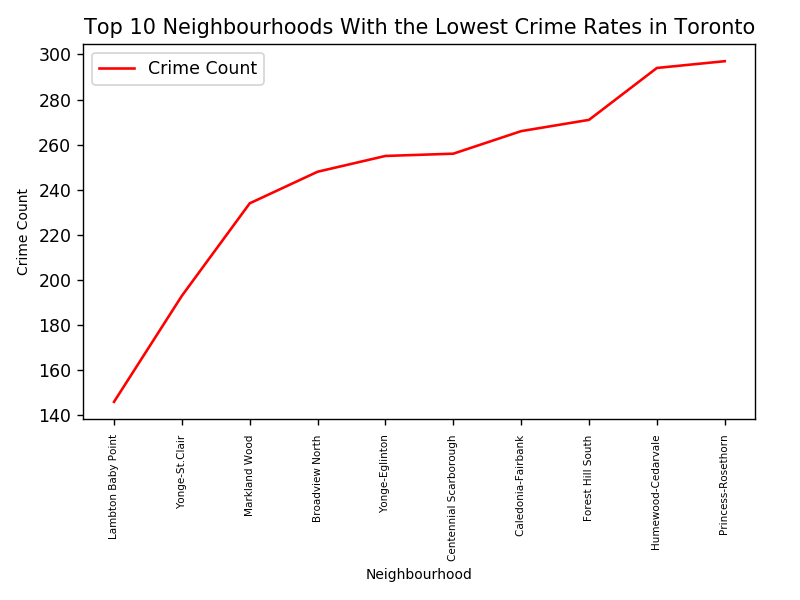

In [35]:
#creating the plot
plt.plot(lowest_crime_rates_top10['Neighbourhood'], lowest_crime_rates_top10['Crime Count'], color='red')
    
plt.legend(loc="best")
plt.title('Top 10 Neighbourhoods With the Lowest Crime Rates in Toronto', fontsize = 12)
plt.xlabel('Neighbourhood', fontsize = 8)
plt.ylabel('Crime Count', fontsize = 8)
plt.xticks(rotation='vertical', fontsize = 6)
plt.tight_layout()
plt.show()

### Examine Clusters

**Cluster 1**

In [30]:
Cluster1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
Cluster1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Woburn,0,Coffee Shop,Park,Business Service,Women's Store,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
9,"Birch Cliff, Cliffside West",0,Park,Café,Skating Rink,Diner,Thai Restaurant,General Entertainment,College Stadium,Convenience Store,Dumpling Restaurant,Dive Bar


**Cluster 2**

In [31]:
Cluster2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
Cluster2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",1,Fast Food Restaurant,Coffee Shop,Hobby Shop,Spa,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,"Rouge Hill, Port Union, Highland Creek",1,Breakfast Spot,Bar,Burger Joint,Women's Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,"Guildwood, Morningside, West Hill",1,Park,Restaurant,Fast Food Restaurant,Sports Bar,Thrift / Vintage Store,Rental Car Location,Moving Target,Electronics Store,Breakfast Spot,Mexican Restaurant
4,Cedarbrae,1,Indian Restaurant,Bakery,Coffee Shop,Flower Shop,Lounge,Fried Chicken Joint,Bank,Gas Station,Caribbean Restaurant,Athletics & Sports
5,Scarborough Village,1,Ice Cream Shop,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Electronics Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
6,"Kennedy Park, Ionview, East Birchmount Park",1,Coffee Shop,Discount Store,Hobby Shop,Grocery Store,Department Store,Sandwich Place,Bus Station,Light Rail Station,Auto Garage,Intersection
7,"Golden Mile, Clairlea, Oakridge",1,Intersection,Diner,Bakery,Bus Line,Metro Station,Convenience Store,Pharmacy,Coffee Shop,Soccer Field,Park
8,"Cliffside, Cliffcrest, Scarborough Village West",1,Pharmacy,Hardware Store,Burger Joint,Auto Workshop,Farm,Fast Food Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
10,"Dorset Park, Wexford Heights, Scarborough Town...",1,Indian Restaurant,Bakery,Electronics Store,Fast Food Restaurant,Rental Service,Chinese Restaurant,Pet Store,Gym,Light Rail Station,Coffee Shop
11,"Wexford, Maryvale",1,Pizza Place,Burger Joint,Rental Car Location,Smoke Shop,Fish Market,Seafood Restaurant,Café,Korean Restaurant,Bakery,Breakfast Spot


To conclude, Scarborough is one the neighborhoods with the lowest crime rates in Toronto. From the results of clustered neighborhoods, we can know that Cluster 1 is a quieter cluster with neighborhoods filled with coffee shops, cafes and parks whereas cluster 2 is a busy cluster of neighborhoods, filled with restaurants, shops and stores.

Our recommendation would be to pick Scarborough as a borough and all of the neighborhoods in cluster 2 **except** Clarks Corners, Tam O'Shanter, Sullivan as an optimal neighborhood to open a shopping mall. Although the neighbourhoods mentioned have relative low crime rate, due to the 1st Most Common Venue is shopping mall, Clarks Corners, Tam O'Shanter, Sullivan will not be a suitable place to open a shopping mall.

## Discussion

Among numerous factors that determine a good neighborhood to start a business, we only took into consideration what type of venues are popular and how many crime incidents are recorded for the sake of simplification. This means that serious crimes like homicide were treated the same as a comparatively petty crime like shoplifting. Moreover, the number of stores in the neighborhood may be as important as what type of stores there are.

To overcome the limitations of this study, we will need further data such as distance to the city center, housing prices,schools' location and many more. Also, taking crime categories into factors and weighting them differently may be helpful. Nevertheless, this research was still meaningful in that we were able to explore the neighborhoods in depth.

## Conclusion

Purpose of this project was to help stakeholders identify optimal neighbourhoods in Toronto to open a shopping mall. Three main data sources were used: Foursquare, Toronto Neighbourhood Profiles, and Toronto Crime Rate by Neighbourhood.In this project, we managed to cluster the city of Toronto using demographic data by neighbourhoods. This helps us identify which neighbourhoods are the most adequate for opening a new shopping mall of a specific type. From our analysis, we have found that Scarborough is the best place to build a shopping mall, based on the safety and atmosphere of the neighborhood.